# MEB: Coarsen Multiple Eigenvectors around $\lambda = 0$

## Set up Fine-level Eigenroblem

In [2]:
%run /Users/olivne/multigrid/amgplus/src/helmholtz/startup.ipy
from scipy.sparse.linalg import eigsh
from scipy.linalg import subspace_angles
import meb.coarsening

In [3]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 100
domain_size = 1
discretization = "3-point"
lam = 0   # lambda = -k^2 in Helmholtz.

# Test vectors.
num_tv = 10
num_sweeps_tv = 20 # None

# Relaxation shrinkage.
leeway_factor = 1.2

# Interpolation.
interpolation_method = "ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5

# Cycles.
nu_values = np.arange(1, 6)

In [5]:
# Create fine-level eigenproblem: -Delta u = lam u with periodic BC.
level = meb.coarsening.create_eigenproblem(domain_size, n, hm.solve.relax.GsRelaxer)
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)
_LOGGER.info("lam {}".format(lam))
_LOGGER.info("domain size {} n {} h {}".format(domain_size, n, h))

TypeError: create_finest_level() got an unexpected keyword argument 'b'

## Relaxation

INFO     relax
INFO     Iter     |r|                         |x|         RER
INFO     0     1.106e+00                    4.468e-01    2.470
INFO     1     4.119e-01 (0.373) [0.373]    2.516e-01    1.645 (0.665)
INFO     2     1.617e-01 (0.393) [0.383]    1.848e-01    0.886 (0.538)
INFO     3     6.945e-02 (0.430) [0.399]    1.581e-01    0.446 (0.504)
INFO     4     3.468e-02 (0.500) [0.422]    1.441e-01    0.243 (0.548)
INFO     5     2.035e-02 (0.586) [0.451]    1.351e-01    0.152 (0.626)
INFO     6     1.376e-02 (0.674) [0.482]    1.284e-01    0.107 (0.709)
INFO     7     1.025e-02 (0.744) [0.513]    1.231e-01    0.083 (0.776)
INFO     8     8.164e-03 (0.796) [0.542]    1.187e-01    0.069 (0.825)
INFO     9     6.794e-03 (0.832) [0.569]    1.148e-01    0.059 (0.860)
INFO     10    5.828e-03 (0.858) [0.593]    1.115e-01    0.052 (0.884)
INFO     11    5.110e-03 (0.877) [0.614]    1.086e-01    0.047 (0.901)
INFO     12    4.552e-03 (0.891) [0.633]    1.059e-01    0.043 (0.913)
INFO    

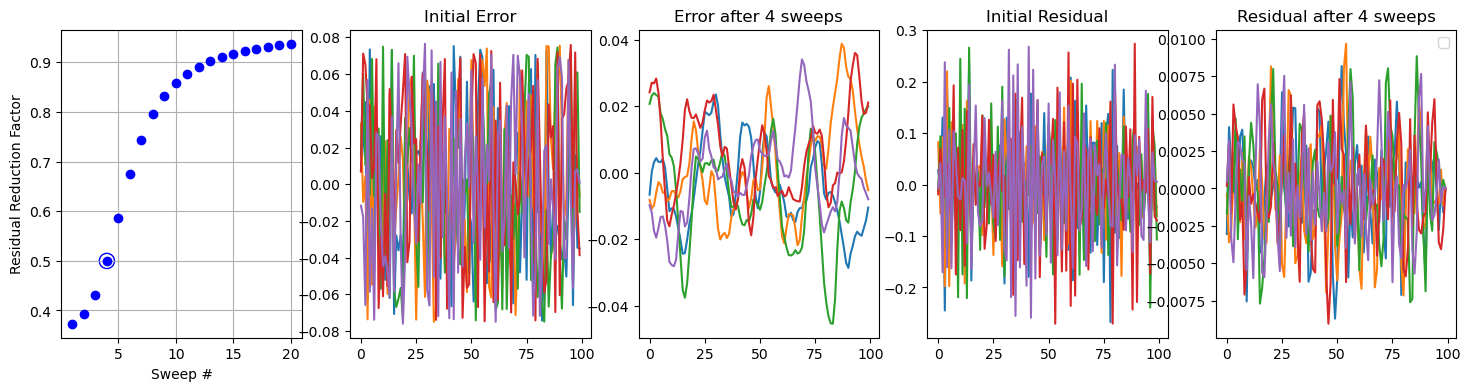

In [189]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

## Test Vectors

In [190]:
# Generate initial test vectors.
level = multilevel[0]
_LOGGER.info("Generating {} TVs with {} sweeps".format(num_tv, num_sweeps_tv))
x = hm.setup.auto_setup.get_test_matrix(a, num_sweeps_tv, num_examples=num_tv)
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))

INFO     Generating 10 TVs with 20 sweeps
INFO     RER 0.172


## Coarsening: Geometric 2/1
Each coarse variable is the average of two adjacent fine variables.

,0,1,2,3,4,5,6,7,8,9
0,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000


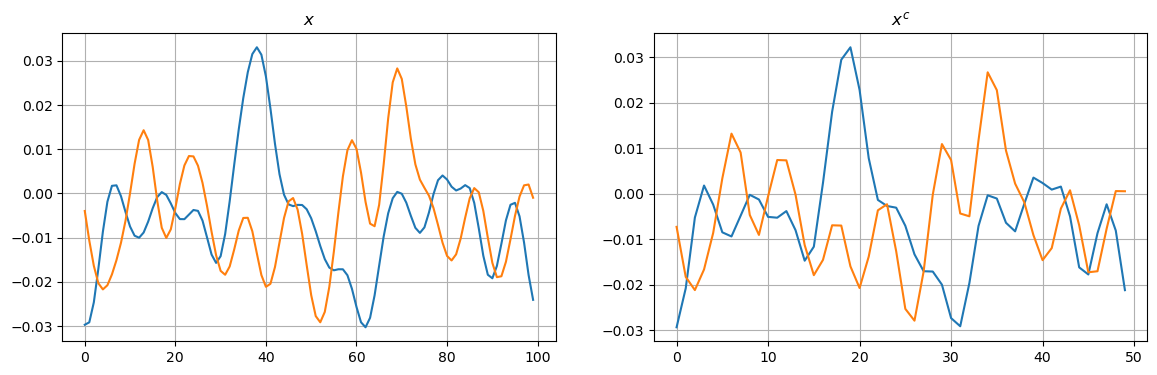

In [191]:
# Coarsening
aggregate_size = 2
num_components = 1

r = helmholtz.repetitive.coarsening_repetitive.Coarsener(np.array([[0.5, 0.5]]))
# Convert to sparse matrix + tile over domain.
R = r.tile(level.a.shape[0] // aggregate_size)

xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
ax = axs[0]
for i in range(2):
    ax.plot(x[:, i])
ax.set_title("$x$")
ax.grid(True)

ax = axs[1]
for i in range(2):
    ax.plot(xc[:, i])
ax.set_title("$x^c$")
ax.grid(True)

### Mock Cycle
Note that injection 2/1 coarsening reports mock cycle rates that stall at $0.5$ with increasing $nu$ (#relaxations per Cgc).

In [192]:
pd.DataFrame([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values], index=nu_values).T

,1,2,3,4,5
0,0.3258,0.1279,0.0817,0.0254,0.0259


## Interpolation

In [193]:
calibers = (2, 3, 4)
p = dict((caliber, hm.setup.auto_setup.create_interpolation(
    x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size,
    num_components=num_components,
    neighborhood=neighborhood, repetitive=False, target_error=0.1,
    caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)) for caliber in calibers)

In [194]:
for caliber in calibers:
    print("caliber", caliber)
    display(pd.DataFrame(p[caliber].todense()[:5, :5]))

caliber 2


,0,1,2,3,4
0,0.7291,0.0000,0.0000,0.0000,0.0000
1,0.7575,0.2759,0.0000,0.0000,0.0000
2,0.2497,0.7871,0.0000,0.0000,0.0000
3,0.0000,0.7786,0.2720,0.0000,0.0000
4,0.0000,0.2498,0.8000,0.0000,0.0000


caliber 3


,0,1,2,3,4
0,1.0311,-0.1929,0.0000,0.0000,0.0000
1,0.9689,0.1929,0.0000,0.0000,0.0000
2,0.1322,1.0177,-0.1556,0.0000,0.0000
3,-0.1322,0.9823,0.1556,0.0000,0.0000
4,0.0000,0.1400,1.0145,-0.1535,0.0000


caliber 4


,0,1,2,3,4
0,0.7883,-0.0881,0.0000,0.0000,0.0000
1,0.8153,0.3709,-0.0993,0.0000,0.0000
2,0.2377,0.9362,-0.1219,0.0000,0.0000
3,-0.0867,0.8591,0.2996,-0.0744,0.0000
4,-0.0461,0.2388,0.9200,-0.1149,0.0000


## Coarse-level Eigenproblem

In [195]:
P = p[2]

In [196]:
PT = P.T
ac = PT @ a @ P
bc = PT @ b @ P

In [197]:
l, v = eigsh(a, M=b, k=n-1)

In [198]:
nc = ac.shape[0]
lc, vc = eigsh(ac, M=bc, k=nc-1)

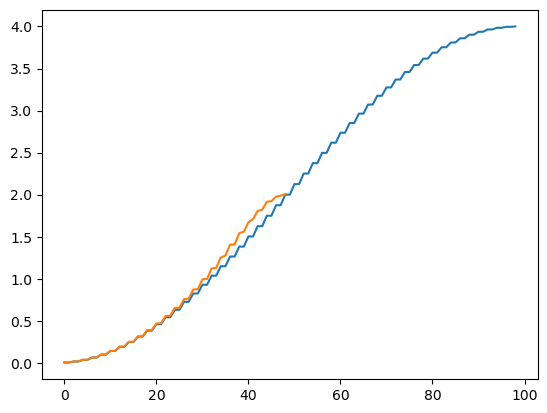

In [199]:
plt.plot(l)
plt.plot(lc)

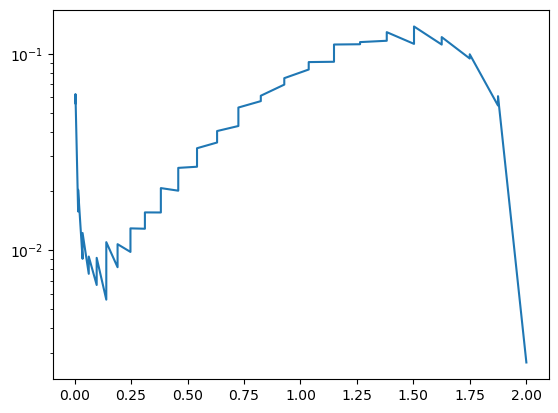

In [200]:
lf = l[:nc-1]
plt.semilogy(lf, np.abs(lc - lf) / np.abs(lf))

In [230]:
angles = [subspace_angles(vf[:, :i], vcf[:, :i])[0] for i in range(1, len(lf) + 1)]
pd.DataFrame(np.stack((lf, lc, np.abs(lf - lc)/np.abs(lf), angles)).T, index=np.arange(1, len(lf) + 1),
            columns=("lam-f", "lam-c", "lam-err", "v-angle"))

,lam-f,lam-c,lam-err,v-angle
1,0.0039,0.0042,0.0559,0.7731
2,0.0039,0.0042,0.0622,0.0319
3,0.0158,0.0160,0.0157,1.1978
4,0.0158,0.0161,0.0203,0.0306
5,0.0354,0.0357,0.0090,0.0312
6,0.0354,0.0359,0.0122,0.0307
7,0.0628,0.0633,0.0076,1.3425
8,0.0628,0.0634,0.0093,0.0307
9,0.0979,0.0985,0.0067,1.0826
10,0.0979,0.0988,0.0091,0.0307


In [220]:
len(angles), len(lf)

(1, 49)

In [202]:
vcf = P @ vc
vf = v[:, :nc-1]

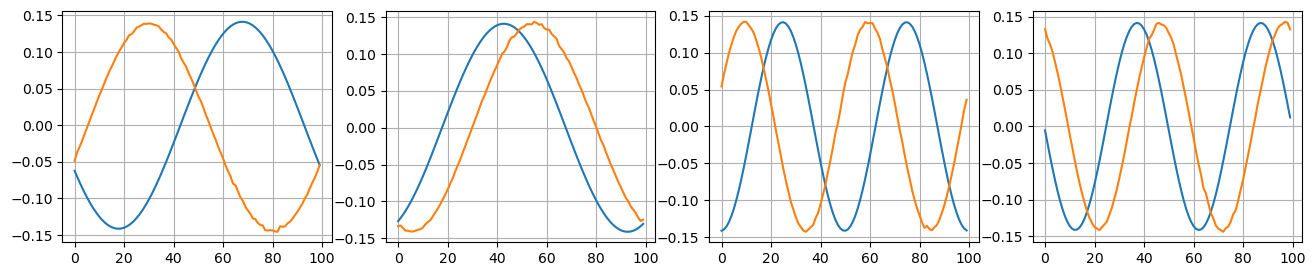

In [203]:
k = 4
fig, axs = plt.subplots(1, k, figsize=(16, 3))
for i, ax in enumerate(axs):
    ax.plot(vf[:, i])
    ax.plot(vcf[:, i])
    ax.grid(True);

In [210]:
pd.DataFrame([subspace_angles(vf[:, :i], vcf[:, :i])[0] for i in range(1, len(lf))]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0.7731,0.0319,1.1978,0.0306,0.0312,0.0307,1.3425,0.0307,1.0826,0.0307,0.5934,0.0318,0.7245,0.0341,1.5106,0.0433,0.6368,0.0515,0.1717,0.0613,0.3020,0.0819,0.2279,0.0976,0.1959,0.1202,1.0242,0.1398,0.3590,0.1713,1.4141,0.2087,1.2131,0.2417,0.3511,0.2841,0.4919,0.3352,0.3947,0.4031,1.1889,0.4811,0.5408,0.5669,1.4942,0.6333,1.2172,0.7235
